# 의료 영상 분석에서의 딥러닝

> #### 오늘의 실습은 아래의 캐글 노트북 참조
> https://www.kaggle.com/amyjang/tensorflow-pneumonia-classification-on-x-rays

#### 일단 단점이 있는데...
- private data privacy로 인해 데이터 구하기 힘듦
- 희귀 질환은 구하기 더 힘듦
- 라벨링에 전문지식이 필요 -> 이는 곧 cost의 상승
- 음성/양성 데이터의 imbalance
- 해석할 때도 전문 지식 필요...

#### 오늘의 데이터
https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia

#### 의료 영상의 종류
- x-ray
- CT
- MRI
- PET

등이 있지만, 오늘은 X-ray를 사용해서 폐렴 진단 딥러닝 모델 개발

#### 폐렴이란?
- https://ko.wikipedia.org/wiki/%ED%8F%90%EB%A0%B4
- 폐에 생기는 염증인데, 염증은 우리 몸을 지키려는 백혈구가 싸우고 있는 곳이라고 생각하면 된단다.

## 실습

### setup

In [1]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings(action='ignore')

> 필요한 변수 생성

In [2]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*' # *은 모든 디렉토리와 파일을 의미합니다.
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

# 프로젝트를 진행할 때 아래 두 변수를 변경해보세요
BATCH_SIZE = 16
EPOCHS = 25

print(ROOT_PATH)

/aiffel/aiffel


In [4]:
AUTOTUNE

-1

In [5]:
tf.data.experimental

<module 'tensorflow._api.v2.data.experimental' from '/opt/conda/lib/python3.7/site-packages/tensorflow/_api/v2/data/experimental/__init__.py'>

> - tf.data.experimental.AUTOTUNE이 뭔지 알아보려 했는데 약간 추상적인 개념이다.
> - 다른 곳을 찾아봐도 결론적으로 데이터 로드 측면에서 효율성을 높여주는 거란다.

### 데이터 가져 오기

In [3]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


In [8]:
print(type(train_filenames))
train_filenames[:5]

<class 'list'>


['/aiffel/aiffel/chest_xray/data/train/NORMAL/IM-0553-0001-0002.jpeg',
 '/aiffel/aiffel/chest_xray/data/train/NORMAL/NORMAL2-IM-0919-0001.jpeg',
 '/aiffel/aiffel/chest_xray/data/train/NORMAL/IM-0149-0001.jpeg',
 '/aiffel/aiffel/chest_xray/data/train/NORMAL/NORMAL2-IM-0443-0001.jpeg',
 '/aiffel/aiffel/chest_xray/data/train/NORMAL/NORMAL2-IM-1162-0001.jpeg']

> - validation data가 너무 없어서 train에서 가져오기
> - train과 val 데이터를 모아서 다시 8:2로 나누기

In [9]:
# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


In [14]:
math.floor(45.4)

45

> - Normal, Pneumonia path 확인하기
> - `2001번째`는 그냥 랜덤으로 뽑아서 pneumonia를 확인한 것 같다.(shuffle 했으니)
> - 그리고 이를 통해 normal, pneumonia 데이터 갯수 확인

In [15]:
print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

Normal image path
/aiffel/aiffel/chest_xray/data/train/NORMAL/NORMAL2-IM-1056-0001.jpeg
Pneumonia image path
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person336_bacteria_1552.jpeg


In [16]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")


COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1072
Pneumonia images count in training set: 3113


> - CNN의 경우 클래스별 데이터 비율이 balance해야 training이 잘 됨
> - 이는 추후 조정할 예정
> - **한편, test, val 데이터의 클래스별 imbalance는 어떻게 할 수 없는 것이고, 학습과는 무관하니 상관하지 않는다.**

> - tf.data 인스턴스로 데이터 불러오기
> - tf.data는 training시 mini-batch로 작업할 수 있게 해줌

In [18]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [19]:
train_list_ds

<TensorSliceDataset shapes: (), types: tf.string>

In [20]:
len(train_list_ds)

4185

In [21]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


> - 현재 데이터에는 라벨이 없다.
> - 파일 path에 normal, pneumonia가 있으니 이를 통해 라벨링 컬럼을 만들자

In [22]:
# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

In [24]:
os.path.sep

'/'

In [28]:
tf.strings.split(train_filenames[0], '/')

<tf.Tensor: shape=(8,), dtype=string, numpy=
array([b'', b'aiffel', b'aiffel', b'chest_xray', b'data', b'train',
       b'NORMAL', b'NORMAL2-IM-1056-0001.jpeg'], dtype=object)>

In [29]:
tf.strings.split(train_filenames[0], '/')[-2]

<tf.Tensor: shape=(), dtype=string, numpy=b'NORMAL'>

> - 이미지 데이터는 사이즈가 제각각인 경우가 있으므로 이미지 사이즈를 통일하는 함수 만들기

In [23]:
# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

> `num_parallel_calls` 파라미터에 위에서 할당한 `AUTOTUNE`변수를 이용하면 더욱 빠르게 데이터를 처리한단다.

In [32]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)d

In [33]:
train_ds

<ParallelMapDataset shapes: ((180, 180, 3), ()), types: (tf.float32, tf.bool)>

In [34]:
len(train_ds)

4185

> 이미지 데이터가 잘 만들어졌는지 확인

In [36]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  False


In [37]:
train_ds.take(1)

<TakeDataset shapes: ((180, 180, 3), ()), types: (tf.float32, tf.bool)>

> - test 데이터셋도 위와 동일한 과정 실행
>   - 파일 불러오기
>   - 파일 이미지 리사이즈
>   - 라벨 붙이기

In [38]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


In [39]:
test_ds

<BatchDataset shapes: ((None, 180, 180, 3), (None,)), types: (tf.float32, tf.bool)>

In [40]:
TEST_PATH

'/aiffel/aiffel/chest_xray/data/test/*/*'

In [41]:
tf.data.Dataset.list_files(TEST_PATH)

<ShuffleDataset shapes: (), types: tf.string>

In [42]:
tf.data.experimental.cardinality(tf.data.Dataset.list_files(TEST_PATH))

<tf.Tensor: shape=(), dtype=int64, numpy=624>

In [43]:
tf.data.experimental.cardinality(tf.data.Dataset.list_files(TEST_PATH)).numpy()

624

> - tf.data 파이프라인을 이용해서 prepare_for_training 함수를 통해 데이터 변환
>   - shuffle : 고정 크기의 버퍼를 만들고 그 안에서 shuffle되게 해줌
>   - repeat : 데이터를 여러번 쓸 수 있게 해줌. repeat()은 자동적으로 사이즈에 맞게 해줌
>   - batch : 배치 사이즈만큼 나눠줌
>   - prefetch : 학습 데이터를 나눠서 가져옴. 첫번째 데이터가 GPU에서 사용되는 동안 두번째 데이터를 CPU에 준비해서 리소스의 유휴 상태를 줄여줌

In [44]:
def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

-----------------------------------------------------------------------
-----------------------------------------------------------------------

In [45]:
train_ds

<PrefetchDataset shapes: ((None, 180, 180, 3), (None,)), types: (tf.float32, tf.bool)>

In [49]:
dj_data = tf.data.Dataset.from_tensor_slices([1,2,3,4,5])
dj_data

<TensorSliceDataset shapes: (), types: tf.int32>

In [51]:
dj_data.shuffle(buffer_size=5)
dj_data

<TensorSliceDataset shapes: (), types: tf.int32>

In [57]:
for i in dj_data.take(1):
    print(i)

tf.Tensor(1, shape=(), dtype=int32)


In [58]:
for i in dj_data:
    print(i)

tf.Tensor(1, shape=(), dtype=int32)
tf.Tensor(2, shape=(), dtype=int32)
tf.Tensor(3, shape=(), dtype=int32)
tf.Tensor(4, shape=(), dtype=int32)
tf.Tensor(5, shape=(), dtype=int32)


In [59]:
dj_data = dj_data.shuffle(buffer_size=5)
for i in dj_data:
    print(i)

tf.Tensor(2, shape=(), dtype=int32)
tf.Tensor(5, shape=(), dtype=int32)
tf.Tensor(3, shape=(), dtype=int32)
tf.Tensor(4, shape=(), dtype=int32)
tf.Tensor(1, shape=(), dtype=int32)


In [60]:
dj_data = dj_data.repeat()
dj_data

<RepeatDataset shapes: (), types: tf.int32>

In [61]:
n = 0
for i in dj_data:
    print(i)
    n += 1
    if n == 15:
        break

tf.Tensor(3, shape=(), dtype=int32)
tf.Tensor(2, shape=(), dtype=int32)
tf.Tensor(5, shape=(), dtype=int32)
tf.Tensor(4, shape=(), dtype=int32)
tf.Tensor(1, shape=(), dtype=int32)
tf.Tensor(3, shape=(), dtype=int32)
tf.Tensor(2, shape=(), dtype=int32)
tf.Tensor(5, shape=(), dtype=int32)
tf.Tensor(4, shape=(), dtype=int32)
tf.Tensor(1, shape=(), dtype=int32)
tf.Tensor(1, shape=(), dtype=int32)
tf.Tensor(3, shape=(), dtype=int32)
tf.Tensor(2, shape=(), dtype=int32)
tf.Tensor(5, shape=(), dtype=int32)
tf.Tensor(4, shape=(), dtype=int32)


In [62]:
dj_data

<RepeatDataset shapes: (), types: tf.int32>

In [64]:
dj_data = dj_data.batch(batch_size=3)
dj_data

<BatchDataset shapes: (None,), types: tf.int32>

In [65]:
dj_data.take(1)

<TakeDataset shapes: (None,), types: tf.int32>

In [66]:
for i in dj_data.take(1):
    print(i)

tf.Tensor([1 2 3], shape=(3,), dtype=int32)


In [67]:
n = 0
for i in dj_data:
    print(i)
    n += 1
    if n == 5:
        break

tf.Tensor([5 2 3], shape=(3,), dtype=int32)
tf.Tensor([1 4 1], shape=(3,), dtype=int32)
tf.Tensor([4 2 5], shape=(3,), dtype=int32)
tf.Tensor([3 1 3], shape=(3,), dtype=int32)
tf.Tensor([4 2 5], shape=(3,), dtype=int32)


In [69]:
dj_data = dj_data.prefetch(buffer_size=4)
dj_data

<PrefetchDataset shapes: (None,), types: tf.int32>

In [70]:
n = 0
for i in dj_data:
    print(i)
    n += 1
    if n == 5:
        break

tf.Tensor([2 5 4], shape=(3,), dtype=int32)
tf.Tensor([3 1 3], shape=(3,), dtype=int32)
tf.Tensor([1 4 2], shape=(3,), dtype=int32)
tf.Tensor([5 3 5], shape=(3,), dtype=int32)
tf.Tensor([2 4 1], shape=(3,), dtype=int32)


---------------------------------------
---------------------------------------

### 데이터 시각화

> - train 배치에서 1개만 꺼내고
> - 이를 image batch와 label batch로 분리
> - 그리고 show_batch 함수를 통해 시각화한다.

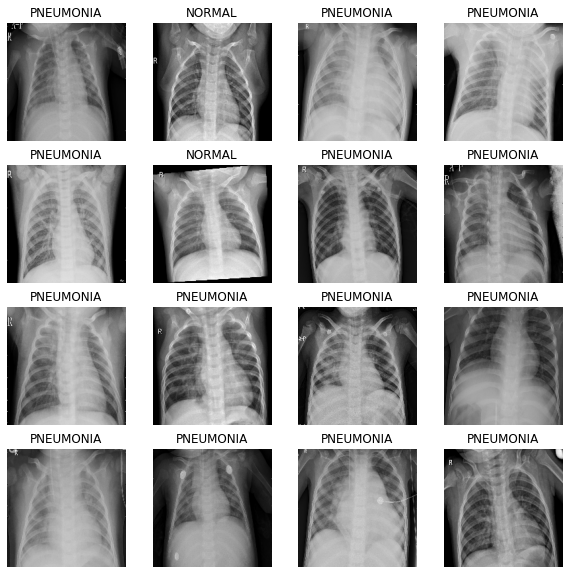

In [71]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4,math.ceil(BATCH_SIZE/4),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

In [72]:
BATCH_SIZE

16

In [79]:
math.ceil(19/3)

7

### CNN 모델링

> #### conv_block() 만들기 함수
> - 구성은 Conv2D를 두 번 진행하고,
> - `BatchNormalization`을 통해 gradient vanishing, gradient exploding 문제 해결
> - MaxPool2D로 downsampling

In [80]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

> #### dense_block() 만들기 함수

In [81]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

> #### 합쳐서 모델 만들기

In [82]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

### 데이터 imblanace 처리

> #### Weight balancing 테크닉
> - 특정 클래스의 loss 값이 더 증가하도록 가중치를 부여하는 법
> - `model.fit(class_weight=)`으로 조정 가능

> - 여기서는 `normal` 클래스의 수가 적었다.
> - 각각 클래스 수가 전체 데이터 수에 차지하는 비율에 반비례하도록 class_weight을 구한다.

In [83]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.95
Weight for PNEUMONIA: 0.67


------------------------------------------------
------------------------------------------------

In [84]:
COUNT_NORMAL

1072

In [85]:
TRAIN_IMG_COUNT

4185

In [86]:
(1 / COUNT_NORMAL)

0.0009328358208955224

In [87]:
(1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)

3.903917910447761

In [88]:
# 직관적 이해는...
# 전체 갯수를 각각 클래스 데이터 갯수로 나눴을 때 나오는 값
# 즉 '클래스 데이터의 몇 배가 전체인지'가 나오는데,
# 이 값은 두 클래스 간 balance가 잘 맞을 때 값이 제일 작다.
# 여튼, 두 클래스 간 imbalance가 크면 각각의 계산 값으로 나오는 게 격차가 커지는데
# 여기서 2로 나눈 건 아마도 클래스가 2개여서 그런 듯 하다.
TRAIN_IMG_COUNT/COUNT_NORMAL

3.903917910447761

### 모델 훈련

> - GPU를 사용할 것이니 GPU 선택
> - 모델은 위의 `build_model()`함수 사용
> - loss는 클래스가 2개(이진 분류)이니 `binary_crossentropy` 사용

In [89]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

> `with tf.device('/GPU:0'):`의 경우 아래와 같이 해석하면 된다.
> - GPU를 수동으로 지정하지 않고 사용할 수도 있지만,
> - 수동으로 지정할 경우 `with tf.device()` 형태도 사용하면 된다.
> - 그리고 이 때 with문 안에 있는 것만 해당 device에서 실행된다.
> - 참고 링크(https://tensorflowkorea.gitbooks.io/tensorflow-kr/content/g3doc/how_tos/using_gpu/)

In [90]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 180, 180, 16)      2320      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
sequential (Sequential)      (None, 45, 45, 32)        2160      
_________________________________________________________________
sequential_1 (Sequential)    (None, 22, 22, 64)        7392      
_________________________________________________________________
sequential_2 (Sequential)    (None, 11, 11, 128)       27072     
_________________________________________________________________
dropout (Dropout)            (None, 11, 11, 128)      

In [91]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/25
261/261 [==============================] - 49s 135ms/step - loss: 0.5397 - accuracy: 0.7182 - precision: 0.9221 - recall: 0.6751 - val_loss: 0.5767 - val_accuracy: 0.7365 - val_precision: 0.7365 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 34s 130ms/step - loss: 0.2322 - accuracy: 0.9007 - precision: 0.9731 - recall: 0.8918 - val_loss: 1.1334 - val_accuracy: 0.7346 - val_precision: 0.7346 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 34s 131ms/step - loss: 0.1884 - accuracy: 0.9257 - precision: 0.9773 - recall: 0.9207 - val_loss: 0.2867 - val_accuracy: 0.8615 - val_precision: 0.8433 - val_recall: 0.9974
Epoch 4/25
261/261 [==============================] - 34s 130ms/step - loss: 0.1656 - accuracy: 0.9408 - precision: 0.9814 - recall: 0.9383 - val_loss: 0.1210 - val_accuracy: 0.9654 - val_precision: 0.9853 - val_recall: 0.9673
Epoch 5/25
261/261 [==============================] - 34s 131ms/step - loss: 0.1548 - accura

### 결과 확인

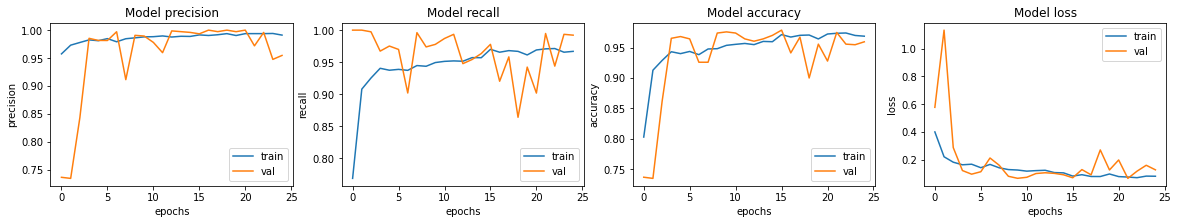

In [92]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [93]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 3s 75ms/step - loss: 1.7025 - accuracy: 0.7292 - precision: 0.6984 - recall: 0.9974
Loss: 1.7025195360183716,
Accuracy: 0.7291666865348816,
Precision: 0.6983842253684998,
Recall: 0.9974358677864075


-------------------------------------------------------
-------------------------------------------------------

array([[<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>]],
      dtype=object)

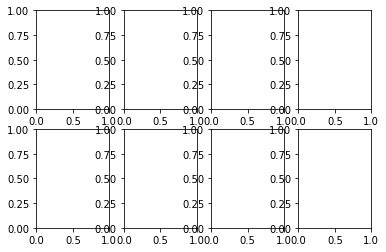

In [94]:
fig, axs = plt.subplots(2, 4)
axs

In [96]:
axs.shape

(2, 4)

In [97]:
axs.ravel().shape

(8,)

-------------------------------------------------------
-------------------------------------------------------

### 결론
- Accuracy로 봤을 때 전체적인 정확도는 70%대 수준으로서 일반적인 의사(약 90%)에 비해 다소 떨어짐


### 개선할 수 있는 방향
- 폐렴 데이터를 기반으로 한 논문 찾아보기
- 이외에 Data Augmentation을 활용하기도 하는데,
- 의학 데이터는 구하기가 쉽지 않아서 일반적인 data augmentation 기법을 많이 사용함
  - 예로는, 이미지 회전
  - 가우시안 노이즈 추가
  - 가우시안 노이즈 추가가 괜찮을 수 있는 이유는 사람마다 장기의 크기가 많이 다르지 않기 때문에
  - 이외에 GAN을 이용한 data augmentation도 있음